In [1]:
from math import sqrt
import os
import glob

from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout
from keras.layers import LSTM
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

import lstm2
import numpy as np
# fix random seed for reproducibility
np.random.seed(7)

Using TensorFlow backend.


In [14]:
source_dir='../data/samples'
models_dir = '../models/lstm/'
supervised_data_dir = '../data/samples_30'
prediction_data_dir = '../data/prediction/samples'
rmse_csv = '../data/rsme_ltsm.csv'
# look back n days. Note: The hight n_lags is, the more overfitting it becomes 
# because there are more features added with the fix number of data we currently have.
# When we add more features later, we may have to cut down n_lags even more
n_lags = 5 
n_forecast = 30 
n_test = 90 # test = last 90 days from data
'''
config_file = '../config/lstm2.config'
source_dir, models_dir, supervised_data_dir, prediction_data_dir, rmse_csv,n_lags, n_forecast, n_test = lstm2.read_config(config_file)
'''


"\nconfig_file = '../config/lstm2.config'\nsource_dir, models_dir, supervised_data_dir, prediction_data_dir, rmse_csv,n_lags, n_forecast, n_test = lstm2.read_config(config_file)\n"

In [15]:
n_features, datasets = lstm2.set_up_data(source_dir, supervised_data_dir, n_lags, n_forecast)

AAPL
(6973, 12)
('Generating', '../data/samples_30/AAPL_supervised.csv')
AMD
(6973, 12)
('Generating', '../data/samples_30/AMD_supervised.csv')
FB
(1331, 12)
('Generating', '../data/samples_30/FB_supervised.csv')
NDAQ
(3821, 12)
('Generating', '../data/samples_30/NDAQ_supervised.csv')
NVDA
(4684, 12)
('Generating', '../data/samples_30/NVDA_supervised.csv')


# Multiple lag timesteps

In [16]:
histories = lstm2.build_models(supervised_data_dir, models_dir, n_test, n_lags, n_features)

('Processing', 'AMD')
Train on 6883 samples, validate on 90 samples
Epoch 1/30
6883/6883 [==============================] - 7s - loss: 0.0461 - val_loss: 0.0284
Epoch 2/30
6883/6883 [==============================] - 6s - loss: 0.0437 - val_loss: 0.0302
Epoch 3/30
6883/6883 [==============================] - 6s - loss: 0.0432 - val_loss: 0.0281
Epoch 4/30
6883/6883 [==============================] - 6s - loss: 0.0428 - val_loss: 0.0404
Epoch 5/30
6883/6883 [==============================] - 6s - loss: 0.0425 - val_loss: 0.0326
Epoch 6/30
6883/6883 [==============================] - 6s - loss: 0.0422 - val_loss: 0.0331
('Saving model to', '../models/lstm/AMD.h5')
('Processing', 'NVDA')
Train on 4594 samples, validate on 90 samples
Epoch 1/30
4594/4594 [==============================] - 5s - loss: 0.0151 - val_loss: 0.0564
Epoch 2/30
4594/4594 [==============================] - 4s - loss: 0.0140 - val_loss: 0.0935
Epoch 3/30
4594/4594 [==============================] - 4s - loss: 0.0138 

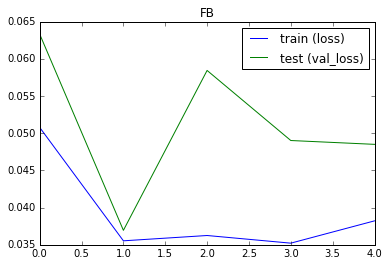

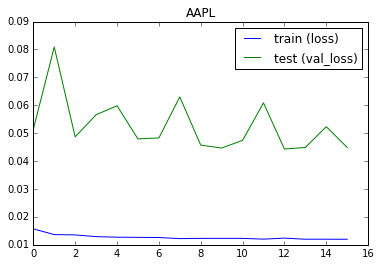

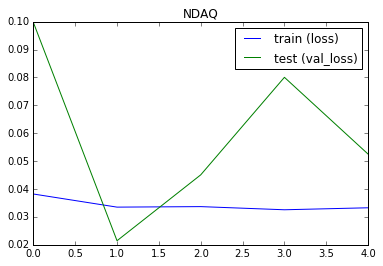

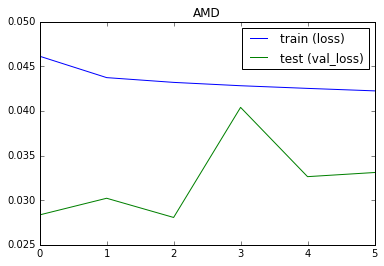

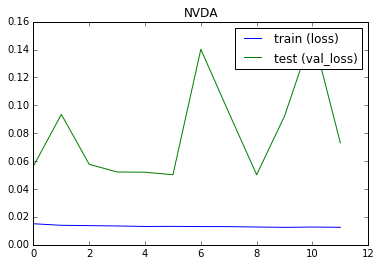

In [17]:
#print(histories)
for stock in histories.keys(): # plot history
    history = histories[stock]
    plt.plot(history.history['loss'], label='train (loss)')
    plt.plot(history.history['val_loss'], label='test (val_loss)')
    plt.title(stock)
    plt.legend()
    plt.show()

In [18]:
predicted_dfs, rmse_df = lstm2.predict_evaluate(models_dir, 
                                                supervised_data_dir, 
                                                prediction_data_dir, 
                                                rmse_csv, 
                                                n_test, n_lags, n_features, n_forecast)

../models/lstm/*.h5
('loading', '../models/lstm/AAPL.h5')
('Reading', '../data/samples_30/AAPL_supervised.csv')
Predicting...
Test RMSE: 8.396
('Writing to', '../data/prediction/samples/AAPL_predicted.csv')
('loading', '../models/lstm/AMD.h5')
('Reading', '../data/samples_30/AMD_supervised.csv')
Predicting...
Test RMSE: 1.853
('Writing to', '../data/prediction/samples/AMD_predicted.csv')
('loading', '../models/lstm/FB.h5')
('Reading', '../data/samples_30/FB_supervised.csv')
Predicting...
Test RMSE: 8.586
('Writing to', '../data/prediction/samples/FB_predicted.csv')
('loading', '../models/lstm/NDAQ.h5')
('Reading', '../data/samples_30/NDAQ_supervised.csv')
Predicting...
Test RMSE: 4.127
('Writing to', '../data/prediction/samples/NDAQ_predicted.csv')
('loading', '../models/lstm/NVDA.h5')
('Reading', '../data/samples_30/NVDA_supervised.csv')
Predicting...
Test RMSE: 17.549
('Writing to', '../data/prediction/samples/NVDA_predicted.csv')


In [19]:
def plot_data(rmse_df, predicted_dfs):
    cnt = 1
    for index, row in rmse_df.iterrows():
        key = row['Stock Model']
        if (cnt % 2 != 0):
            fig, axes = plt.subplots(nrows=1, ncols=2)
            ax=axes[0]
        else:
            ax=axes[1]
        predicted_dfs[key].plot(title=key + ': n_forecast = ' + str(n_forecast) +
                                ', n_lags = ' + str(n_lags) + ': price vs days', 
                                figsize=(15,4), 
                                ax=ax)
        cnt += 1
    plt.show()

In [8]:
# default is sort by 'Day 0 predicted gain'
rmse_df

,Stock Model,rsme,Day 0 predicted gain,Day 0 actual gain,Avg predicted gain,Avg actual gain
4,NVDA,17.202335,0.097389,0.467721,0.028103,0.108065
0,AAPL,8.587734,0.005952,-0.011869,0.003724,0.010531
1,AMD,1.654413,-0.013528,0.140504,-0.003838,0.053256
2,FB,9.220157,-0.015372,-0.016560,0.004124,0.043297
3,NDAQ,6.103521,-0.039559,0.044905,-0.044162,0.038658


In [9]:
#rmse_df#.sort_values(by='Day 0 actual gain', ascending=False)

In [10]:
predicted_dfs2, summary_df = lstm2.read_prediction_files(prediction_data_dir)
# Should be exactly the same as rmse_df above
summary_df

,Stock Model,rsme,Day 0 predicted gain,Day 0 actual gain,Avg predicted gain,Avg actual gain
4,NVDA,17.202335,0.097389,0.467721,0.028103,0.108065
0,AAPL,8.587734,0.005952,-0.011869,0.003724,0.010531
1,AMD,1.654413,-0.013528,0.140504,-0.003838,0.053256
2,FB,9.220157,-0.015372,-0.016560,0.004124,0.043297
3,NDAQ,6.103521,-0.039559,0.044905,-0.044162,0.038658


In [11]:
# Compare 2 dataframes: They should be same
from pandas.util.testing import assert_frame_equal

assert_frame_equal(rmse_df, summary_df)

for key in predicted_dfs.keys():
    print(key)
    assert_frame_equal(predicted_dfs[key], predicted_dfs2[key])

FB
AAPL
NDAQ
AMD
NVDA


# Observations
* RSME values are high for NVDA and AAPL but it's probably because the test dataset is small (90)

* The order of predicted gains is almost the same as the actual gain which is a good sign

# Visualize Results

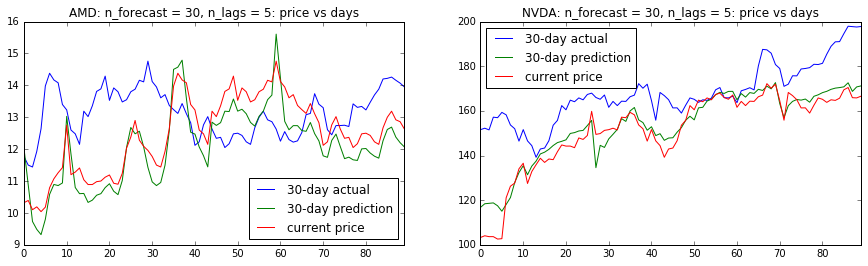

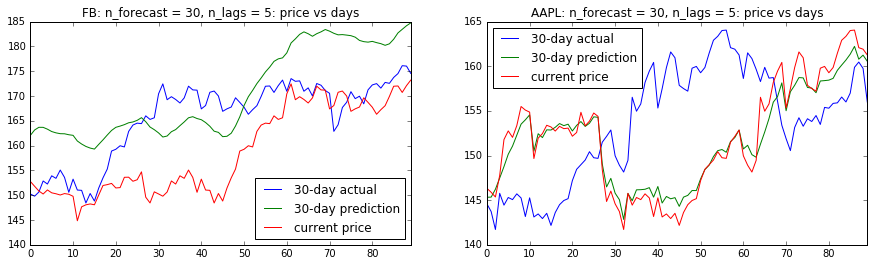

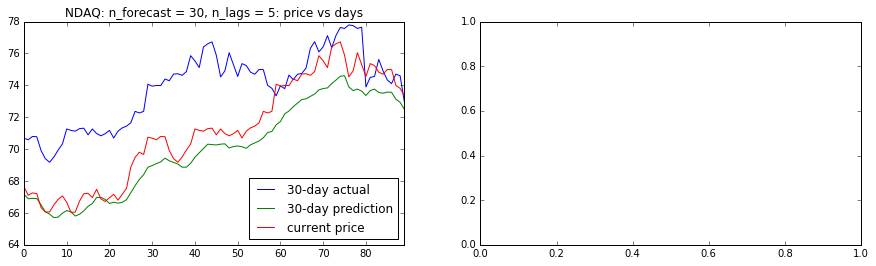

In [20]:
plot_data(rmse_df, predicted_dfs)

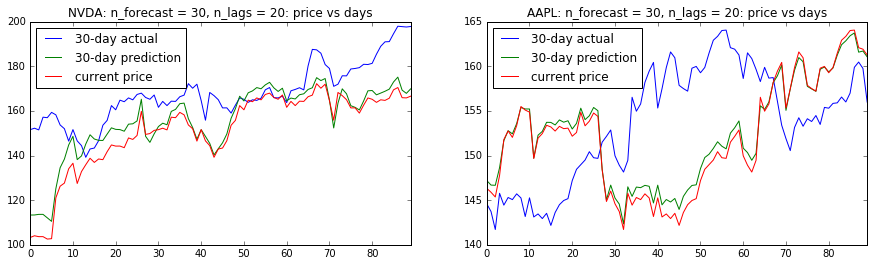

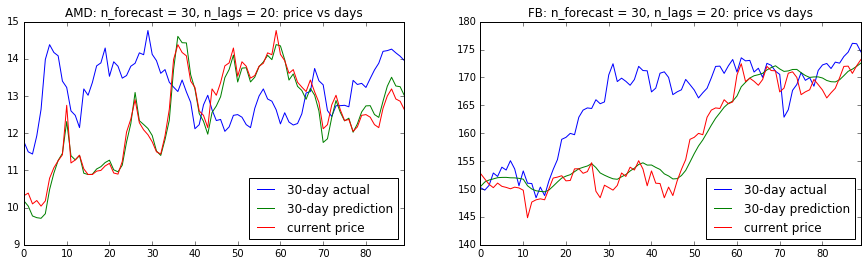

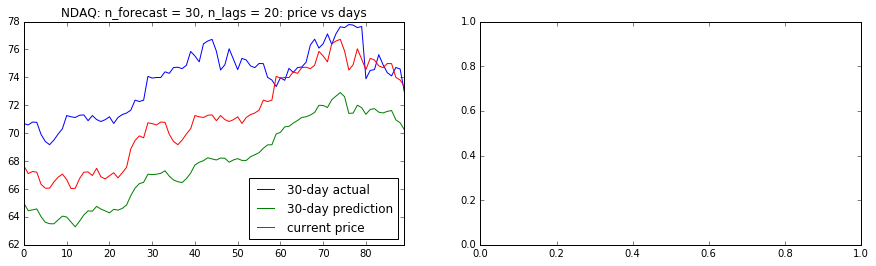

In [13]:
plot_data(rmse_df, predicted_dfs)